# Curve test analysis
## Imports

In [19]:
import ast
import json
import multiprocessing
from copy import deepcopy
from time import sleep

import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

## Setup

In [35]:
data_folder = Path('../data')   # this comes handy for migrations

## Processing functions
### Loading

In [21]:
def parse_results_file(file_path):
    df_data, df_index = [], []

    with open(file_path, 'r') as rf:
        data = json.load(rf)
        for curve_name, curve_data in data.items():
            for params, results in curve_data.items():
                dictionary = deepcopy(results)
                dictionary.update(ast.literal_eval(params))
                df_data.append(dictionary)
                df_index.append(curve_name)
    return df_index, df_data

def plain_numerical2df(df_index, df_data, drop_cols=()):
    columns = set(df_data[0].keys()).difference(drop_cols)
    df_ = pd.DataFrame(df_data, index=df_index, columns=columns).fillna(0).astype(int)
    df_['name'] = df_.index
    df_['sim'] = df_.name.str.contains('sim').astype(int)
    return df_

### Statistical understanding

In [33]:
from scipy.stats import ks_2samp

def plot_df(df_, drop_cols=()):  # args cannot be mutable -- [] would cause problems
    """Logy histogram and relative density 
    => different sizes of sim groups can be shown together
    """
    cols = df_.columns.drop(['name', 'sim',] + list(drop_cols))
    for col in cols:
        ax = df_.groupby('sim')[col].plot.hist(bins=100, logx=False, logy=False, figsize=(14, 6), 
                                               density=False, alpha=0.42, legend=True, xlim=(0, df[col].max()),)
        ax2 = df_.groupby('sim')[col].plot.density(figsize=(14, 6), alpha=1.0, legend=False, logy=False,
                                                   logx=False, xlim=(1, df[col].max()), ax=ax[0].twinx())
        plt.title(col, fontsize='xx-large')
        ax[0].legend(title='sim')
        plt.show()
        
        from scipy.stats import ks_2samp

def kl_divergence(orig_p, orig_q, epsilon=1e-5):
    p, q = get_bins(orig_p), get_bins(orig_q)
    return np.sum(np.where(p != 0, p * np.log(p / (q + epsilon)), 0))

def get_bins(ser):
    hist = np.histogram(ser,
                        density=True,
                        bins=50,
                        range=(0, 5),
                       )
    return hist[0]

def per_group(drop_cols=()):
    def per_group_inner(df_):
        res_ = {}
        for on_col in df_.columns.drop(['name', 'sim',] + list(drop_cols)):
            res_[(on_col, 'ks_stat', )] = ks_2samp(df_.loc[df_.sim == 0, on_col],
                                                df_.loc[df_.sim == 1, on_col])[0]  # we need only the first value
            res_[(on_col, 'kl_stat', )] = kl_divergence(df_.loc[df_.sim == 0, on_col],
                                                       df_.loc[df_.sim == 1, on_col])
        columns=pd.MultiIndex.from_tuples(res_.keys(), names=['col', 'stat'])
        return pd.Series(res_, index=columns)
    return per_group_inner

### Machine learning understanding
...it's so simple to code, you have to give it a try!
I would test it again, once there are many test results per curve => the random forest / KMeans could find something interesting (== they would produce reasonable results => we can investigate those results)

In [23]:
import matplotlib.pyplot as plt  # doctest: +SKIP
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn import svm
import sklearn
from sklearn import ensemble

def eval_classifier(classifier, X, y, ax):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    classifier.fit(X_train, y_train)
    plot_confusion_matrix(classifier, X_test, y_test, ax=ax)  # doctest: +SKIP
    
def eval_classifiers(df_, drop_cols=()):
    """Check performance of different classifiers on test set (last 20 %)"""
    df_ = df.sample(frac=1, random_state=0)  # should we 
    X = df_.drop(columns=['sim', 'name', ] + list(drop_cols))
    y = df_.sim
    
    classifiers = [   # The hyperparams could be tuned/autotuned
        SVC(random_state=0, degree=3),
        SGDClassifier(loss="hinge", penalty="l2", max_iter=100),
        sklearn.neighbors.KNeighborsClassifier(n_neighbors=2),
        ensemble.RandomForestClassifier(10),
    ]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))   # nrows * ncols = len(classifiers)

    for cls, ax in zip(classifiers, axes.flatten()):
        eval_classifier(cls, X, y, ax=ax)
        ax.title.set_text(type(cls).__name__)
        ax.title.set_fontsize('xx-large')
    
    plt.tight_layout()  
    plt.show()

## A05
> It would be great to have a real description here

### Load data

In [36]:
print(list(data_folder.glob('*.json')))   # list all files -> could be used to auto parse all files

drop_cols = ('l', )  # comma needed for tuples
df = plain_numerical2df(*parse_results_file(data_folder / 'a05_filtered.json'))  # *does tuple unpacking
df

[PosixPath('../data/a05.json'), PosixPath('../data/a05_filtered.json'), PosixPath('../data/a25.json')]


,relative,full,l,least,name,sim
prime192v2,1,3,2,3,prime192v2,0
prime192v2,1,8,3,8,prime192v2,0
prime192v2,5,20,5,4,prime192v2,0
prime192v2,3,6,7,2,prime192v2,0
prime192v3,1,3,2,3,prime192v3,0
...,...,...,...,...,...,...
P-224,1,24,7,24,P-224,0
prime239v1,1,3,2,3,prime239v1,0
prime239v1,1,8,3,8,prime239v1,0
prime239v1,1,12,5,12,prime239v1,0


### Numerical comparison

In [25]:
display(df.describe())
display(df.groupby('sim').describe().T)

,relative,full,l,least,sim
count,216796.000000,216796.000000,216796.000000,216796.000000,216796.000000
mean,1.675220,8.741162,4.250000,6.960719,0.999815
std,1.333755,9.105470,1.920291,8.770193,0.013582
min,1.000000,2.000000,2.000000,2.000000,0.000000
25%,1.000000,3.000000,2.750000,3.000000,1.000000
50%,1.000000,6.000000,4.000000,3.000000,1.000000
75%,2.000000,8.000000,5.500000,8.000000,1.000000
max,7.000000,48.000000,7.000000,48.000000,1.000000


sim                     0              1
relative count  40.000000  216756.000000
         mean    1.950000       1.675169
         std     1.632208       1.333693
         min     1.000000       1.000000
         25%     1.000000       1.000000
         50%     1.000000       1.000000
         75%     3.000000       2.000000
         max     5.000000       7.000000
full     count  40.000000  216756.000000
         mean   12.800000       8.740413
         std    12.030304       9.104713
         min     2.000000       2.000000
         25%     3.000000       3.000000
         50%     8.000000       6.000000
         75%    17.000000       8.000000
         max    48.000000      48.000000
l        count  40.000000  216756.000000
         mean    4.250000       4.250000
         std     1.944750       1.920291
         min     2.000000       2.000000
         25%     2.750000       2.750000
         50%     4.000000       4.000000
         75%     5.500000       5.500000
         max     7.000000       7.000000
least    count  40.000000  216756.000000
         mean    9.700000       6.960213
         std    12.239491       8.769387
         min     2.000000       2.000000
         25%     3.000000       3.000000
         50%     4.000000       3.000000
         75%     9.000000       8.000000
         max    48.000000      48.000000

### Visual comparison

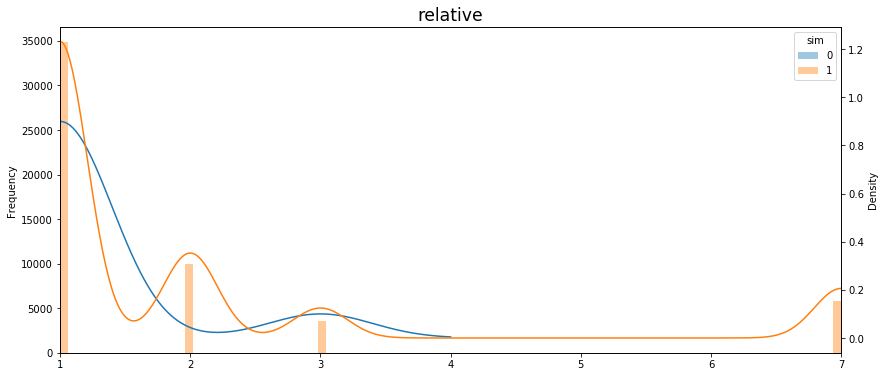

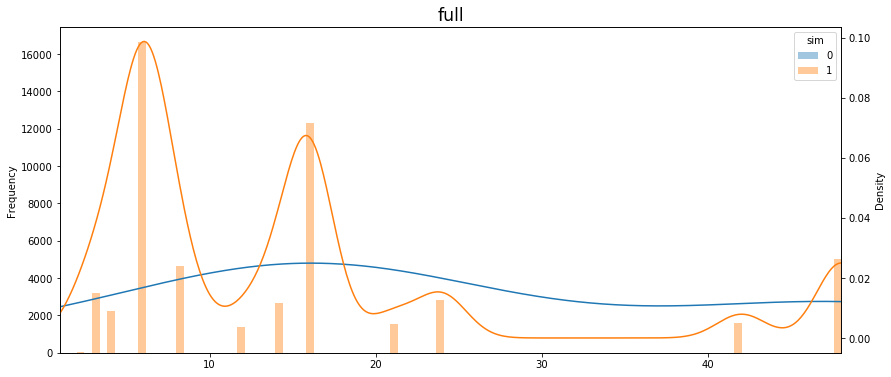

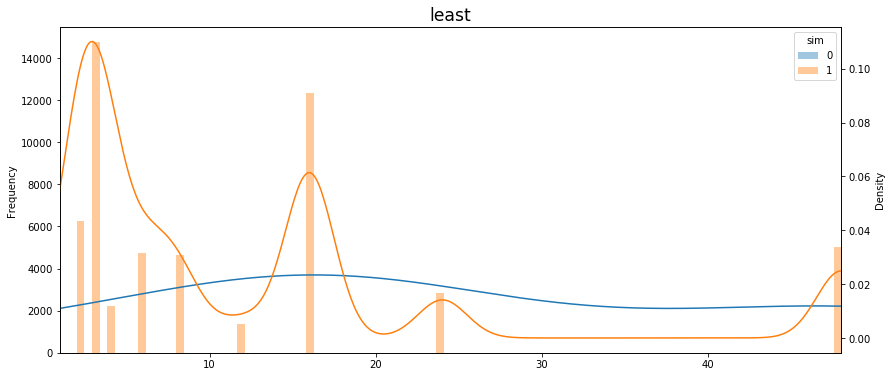

In [37]:
# the 'l' col needs to be skipped as it contains only 1 value 
# and causes LinAlg error when calculating the density
plot_df(df.loc[df.l == 7], drop_cols)

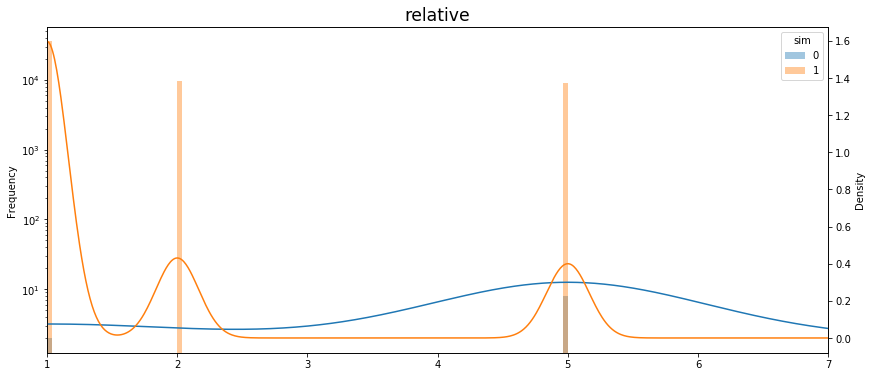

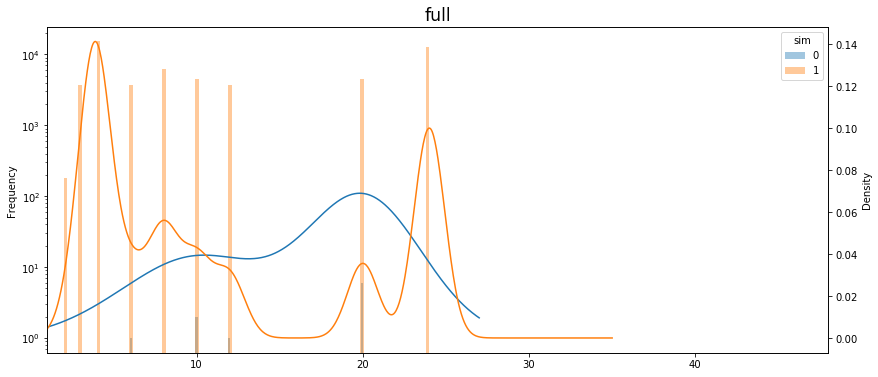

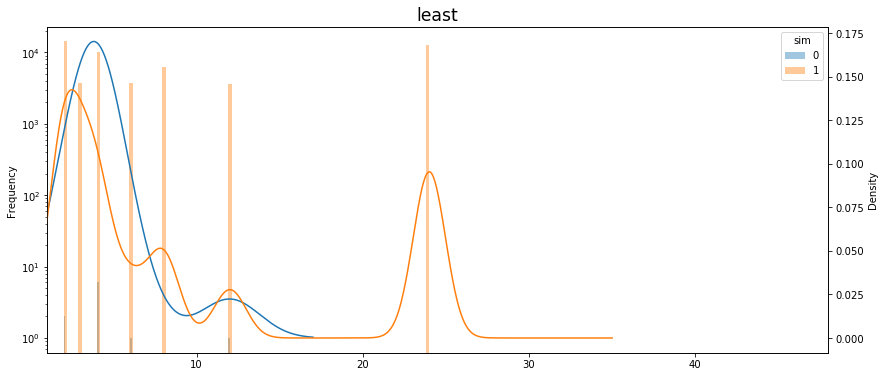

In [27]:
plot_df(df.loc[df.l == 5], drop_cols)

### Metric comparison

In [28]:
df.groupby('l').apply(per_group(drop_cols))  # any groupby producing non-zero groups is supported 

/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in m

col   relative                 full                least           
stat   ks_stat    kl_stat   ks_stat    kl_stat   ks_stat    kl_stat
l                                                                  
2     0.000000  -0.000010  0.000000  -0.000010  0.000000  -0.000010
3     0.252453   1.400560  0.546777  19.457628  0.546777   5.093939
5     0.635262  10.260787  0.436142        NaN  0.314475   3.741997
7     0.256733   2.315999  0.469507        NaN  0.527674  13.133328

### ML comparison

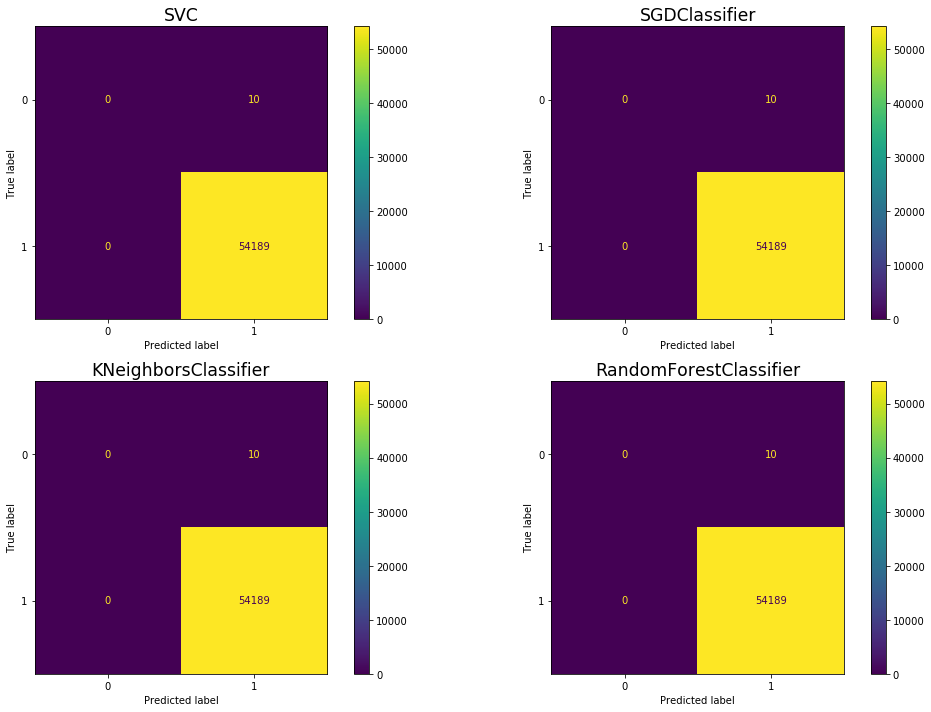

In [29]:
eval_classifiers(df, drop_cols)

The ML classification is not good for any of the algorithms.

## a25
> It would be great to have a real description here
### Load data

In [30]:
drop_cols = ('trace_factorization', )  # comma needed for tuples
df_index, df_data = parse_results_file(data_folder / 'a25.json')
df = plain_numerical2df(df_index, df_data, drop_cols)  # *does tuple unpacking
df['trace_factorization'] = pd.Series([np.array(x['trace_factorization'])[:,0]   # ignore ones
                                       for x in df_data], index=df_index)
df

,number_of_factors,name,sim,trace_factorization
secp112r1,5,secp112r1,0,"[5, 13, 367, 653, 282930227]"
secp192r1,5,secp192r1,0,"[89, 179, 383, 6196490257, 835990267859]"
secp256r1,5,secp256r1,0,"[113, 2521, 12713, 3450079, 713804004685250272..."
x962_sim_128_seed_diff_525386,4,x962_sim_128_seed_diff_525386,1,"[3, 7, 1348597, 1211443907881]"
x962_sim_128_seed_diff_1788512,4,x962_sim_128_seed_diff_1788512,1,"[23, 251, 269, 21956051508929]"
...,...,...,...,...
prime256v1,5,prime256v1,0,"[113, 2521, 12713, 3450079, 713804004685250272..."
Fp256BN,3,Fp256BN,0,"[38113, 39563, 225671696671686819525839357333]"
secp256k1,2,secp256k1,0,"[673, 642526577363535894282943337876185999]"
ansip256k1,2,ansip256k1,0,"[673, 642526577363535894282943337876185999]"


### Generate reasonable features

In [31]:
def max_min_ratio(x):
    return np.max(x) / np.min(x)

feature_fns = np.min, np.max, np.mean, np.median, max_min_ratio

for fn in feature_fns:
    df[f'log10({fn.__qualname__})'] = np.log10(df.trace_factorization.apply(fn).astype(float))

### Statistics

### Numerical comparison

,number_of_factors,sim,log10(amin),log10(amax),log10(mean),log10(median),log10(max_min_ratio)
count,37835.000000,37835.000000,37835.000000,37835.000000,37835.000000,37835.000000,37835.000000
mean,4.084736,0.997938,1.254064,12.060262,11.494241,4.993457,10.806198
std,1.427054,0.045358,2.949400,3.748045,3.848623,4.896034,4.161236
min,1.000000,0.000000,0.301030,0.477121,0.477121,0.477121,0.000000
25%,3.000000,1.000000,0.301030,9.077552,8.441475,1.851258,7.919536
50%,4.000000,1.000000,0.301030,11.735448,11.134503,3.216957,10.651371
75%,5.000000,1.000000,0.845098,15.048635,14.513575,5.850254,13.959781
max,10.000000,1.000000,29.110052,35.807891,35.506861,35.506861,33.652243


sim                                 0             1
number_of_factors    count  78.000000  37757.000000
                     mean    3.589744      4.085759
                     std     1.685969      1.426319
                     min     1.000000      1.000000
                     25%     3.000000      3.000000
                     50%     3.500000      4.000000
                     75%     5.000000      5.000000
                     max     8.000000     10.000000
log10(amin)          count  78.000000  37757.000000
                     mean    2.455283      1.251583
                     std     4.095216      2.946140
                     min     0.301030      0.301030
                     25%     0.477121      0.301030
                     50%     1.077668      0.301030
                     75%     2.811305      0.845098
                     max    29.110052     19.563892
log10(amax)          count  78.000000  37757.000000
                     mean   17.440379     12.049148
                     std     9.158903      3.721003
                     min     0.477121      3.167613
                     25%    12.542007      9.076009
                     50%    17.291197     11.726212
                     75%    21.853579     15.037415
                     max    35.807891     19.563892
log10(mean)          count  78.000000  37757.000000
                     mean   16.952663     11.482964
                     std     9.086576      3.822622
                     min     0.477121      2.547364
                     25%    11.876947      8.438439
                     50%    16.770690     11.125461
                     75%    21.154609     14.502280
                     max    35.506861     19.563892
log10(median)        count  78.000000  37757.000000
                     mean    7.332888      4.988624
                     std     8.583507      4.884576
                     min     0.477121      0.477121
                     25%     1.954243      1.851258
                     50%     4.104248      3.214049
                     75%     8.744259      5.845231
                     max    35.506861     19.563892
log10(max_min_ratio) count  78.000000  37757.000000
                     mean   14.985097     10.797565
                     std     9.288621      4.139993
                     min     0.000000      0.000000
                     25%     8.892879      7.917634
                     50%    15.370289     10.645460
                     75%    20.250503     13.949272
                     max    33.652243     18.962057

### Visual comparison

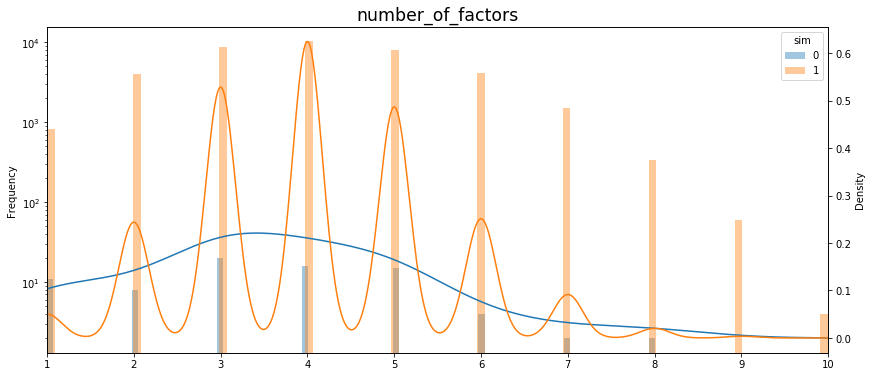

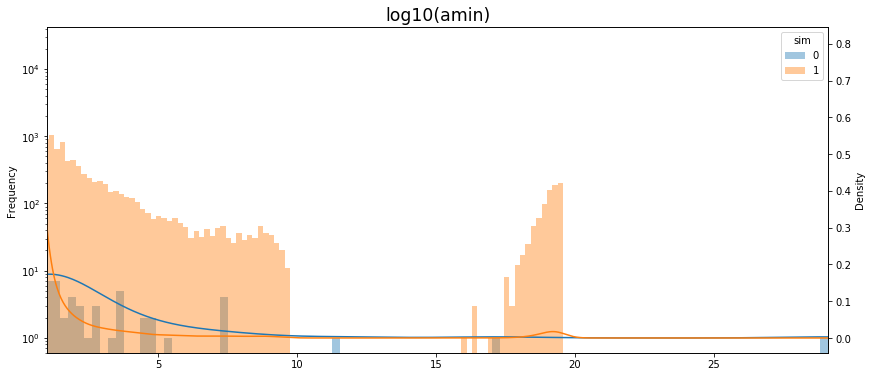

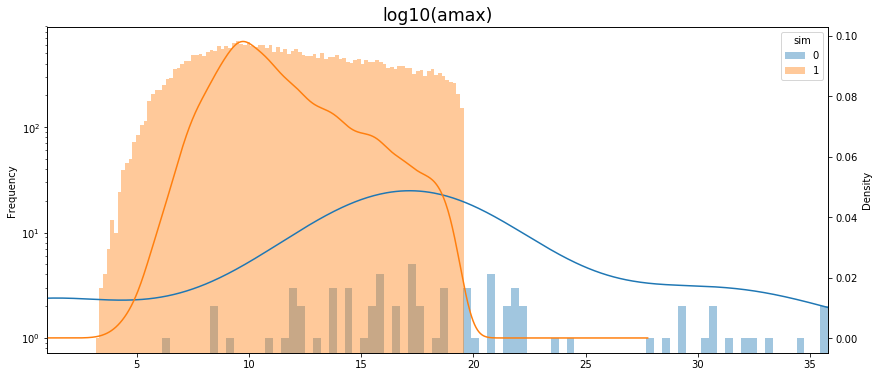

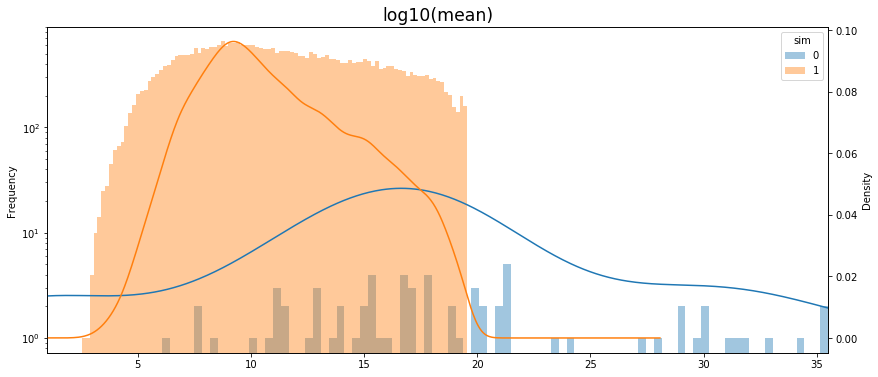

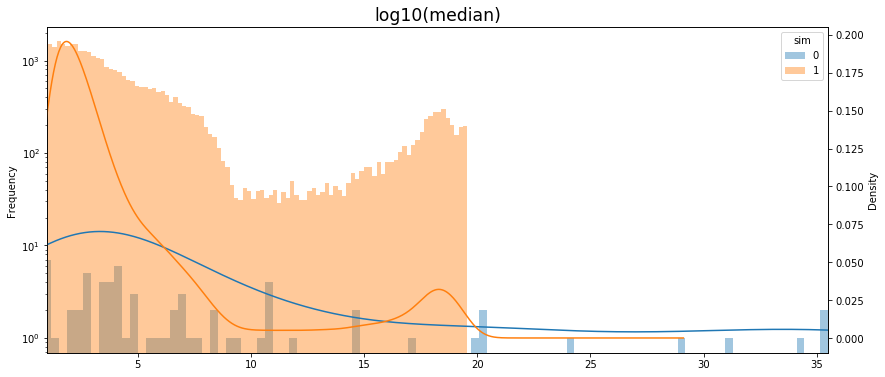

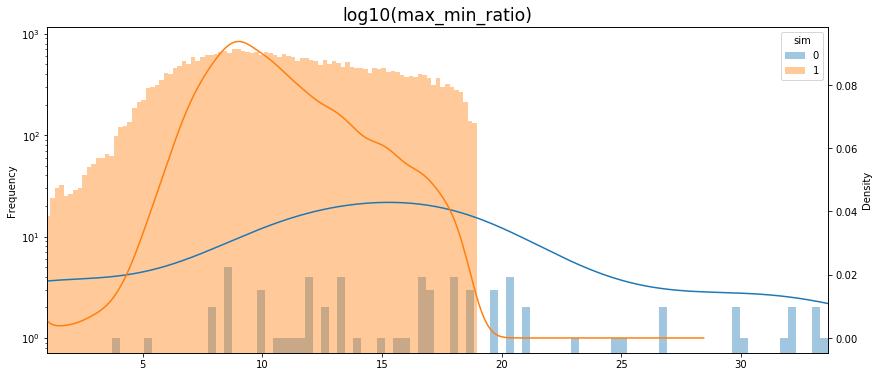

### Metric comparison

/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/opt/SageMath/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in m

col  number_of_factors           log10(amin)           log10(amax)  \
stat           ks_stat   kl_stat     ks_stat   kl_stat     ks_stat   
True          0.142397  1.707133    0.425758  9.097128    0.424721   

col              log10(mean)             log10(median)             \
stat     kl_stat     ks_stat     kl_stat       ks_stat    kl_stat   
True  138.155106    0.427873  138.155106      0.168813  11.931369   

col  log10(max_min_ratio)             
stat              ks_stat    kl_stat  
True             0.375993  10.660652

### ML comparison

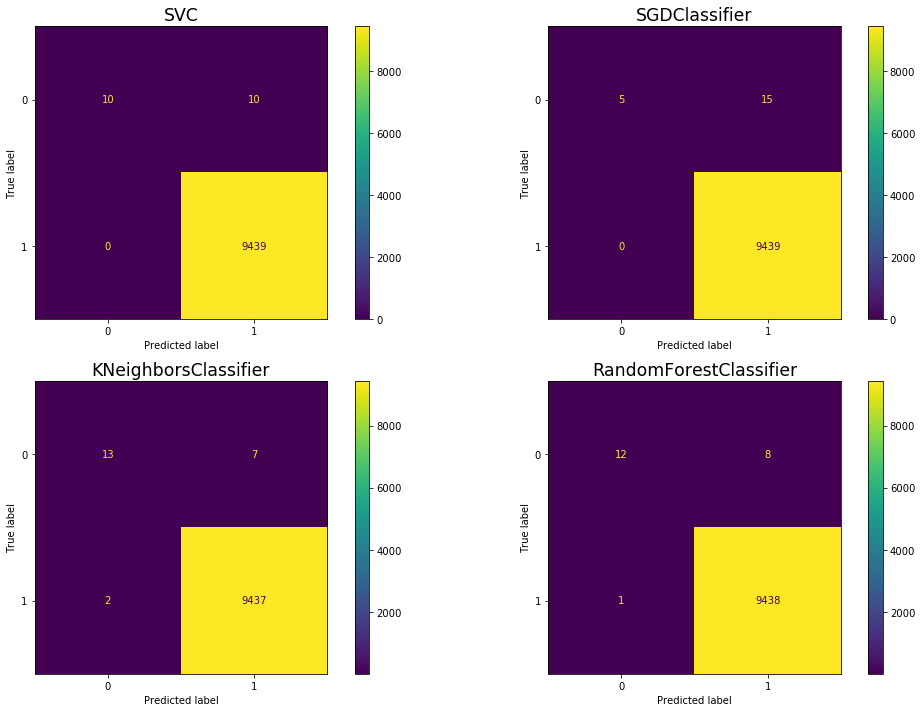

In [32]:
display(Markdown('### Numerical comparison'))
display(df.describe())
display(df.groupby('sim').describe().T)

display(Markdown('### Visual comparison'))
plot_df(df, drop_cols)   # subset it or something

display(Markdown('### Metric comparison'))
display(df.groupby(pd.Series(True, index=df.index)).apply(per_group(drop_cols)))   # consistency with groupby
# display(per_group(['trace_factorization'])(df).to_frame().T)   # those 2 lines are equivalent

display(Markdown('### ML comparison'))
eval_classifiers(df, drop_cols)

Those are some reasonable results for basic ML classifiers with un-tuned hyperparameters.

## Playground